# 1) Creating Monthly Mean SST Dataset

In [1]:
# Read in data
import requests
import pandas as pd
import json
import numpy as np
from datetime import datetime
import time
import xarray as xr
url = 'https://cds.climate.copernicus.eu/how-to-api'
key = 'db508619-3084-4ad8-ac25-a724a48f2b9e'

# attempt to import data with help of website code 
import cdsapi

dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "variable": [
        "total_column_water_vapour",
        "sea_surface_temperature"
    ],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "grib",
    "download_format": "unarchived",
    "area": [65, -60, -65, 120]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


In [2]:
pip install cfgrib eccodes


Note: you may need to restart the kernel to use updated packages.


In [3]:
path = '/home/alissah3/test/ATMS-523-Module-4/bf692d92e3194940b4b23cb2cc9f8425 (1).grib'
ds = xr.open_dataset(path, engine = 'cfgrib')

Ignoring index file '/home/alissah3/test/ATMS-523-Module-4/bf692d92e3194940b4b23cb2cc9f8425 (1).grib.5b7b6.idx' older than GRIB file


In [4]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB -60.0 -59.75 -59.5 ... 119.5 119.8 120.0
    valid_time  (time) datetime64[ns] 4kB ...
Data variables:
    tcwv        (time, latitude, longitude) float32 829MB ...
    sst         (time, latitude, longitude) float32 829MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-26T01:30 GRIB to CDM+CF via cfgrib-0.9.1...

# 2) Compute Anomalies 

In [5]:
import numpy as np
import xarray as xr

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)

    anom = anom.unify_chunks()
    safe_std = safe_std.unify_chunks()

    z = anom.groupby(key) / safe_std
    return anom, z

In [6]:
# Detrend
ds = ds.chunk({"time": -1})
detr = linear_detrend(ds[["sst", "tcwv"]], time_dim="time")
detr = detr.unify_chunks()

/home/alissah3/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [7]:
# monthly anoms & z score
anom, z = monthly_anom_and_z(detr, time_dim="time", base_period=("1981-01-01", "2010-12-31"))

In [8]:
anom

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      (time) int64 4kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * time        (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
    step        (time) timedelta64[ns] 4kB 00:00:00 00:00:00 ... 00:00:00
    surface     (time) float64 4kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB -60.0 -59.75 -59.5 ... 119.5 119.8 120.0
    valid_time  (time) datetime64[ns] 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    month       (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst         (time, latitude, longitude) float32 829MB dask.array<chunksize=(1, 521, 721), meta=np.ndarray>
    tcwv        (time, latitude, longitude) float32 829MB dask.array<chunksize=(1, 521, 721), meta=np.ndarray>

# 3) EOF Analysis

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from eofs.xarray import Eof

sst_chunked = anom['sst'].chunk({"time": -1})
lat = sst_chunked.latitude.values
coslat = np.cos(np.deg2rad(lat))
wgts = np.sqrt(coslat)[:, np.newaxis]


In [ ]:
solver = Eof(sst_chunked, weights=wgts)

/home/alissah3/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


/home/alissah3/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [11]:
n_eofs = 5

# EOFs: spatial patterns
eofs = solver.eofsAsCorrelation(neofs=n_eofs)

# PCs: time series
pcs = solver.pcs(npcs=n_eofs, pcscaling=1)

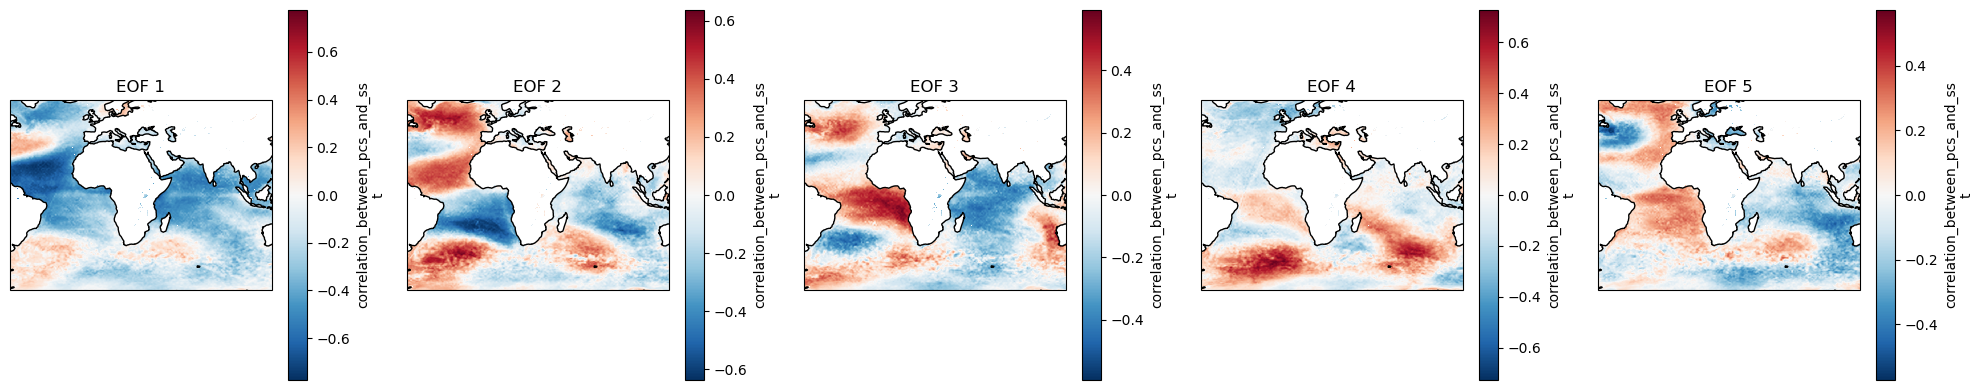

In [12]:
import cartopy.crs as ccrs

fig, axes = plt.subplots(1, n_eofs, figsize=(20,4), subplot_kw={'projection': ccrs.PlateCarree()})

for i in range(n_eofs):
    ax = axes[i]
    eof_i = eofs[i, :, :]
    eof_i.plot(ax=ax, transform=ccrs.PlateCarree(),
               cmap='RdBu_r')
    ax.coastlines()
    ax.set_title(f'EOF {i+1}')

plt.tight_layout()
plt.show()

# 4) Plot Percent of Variance

In [13]:
varfrac = solver.varianceFraction(neigs=10)

varper = varfrac * 100

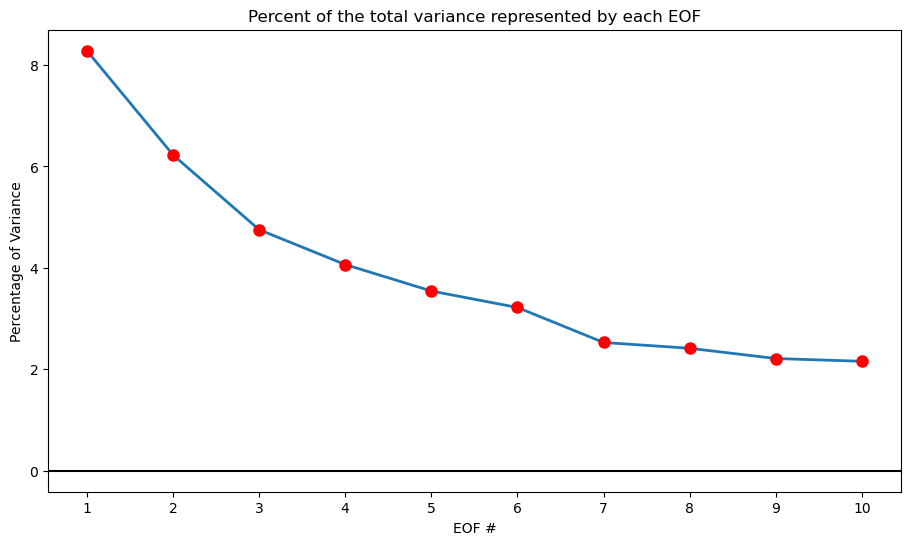

In [14]:
plt.figure(figsize=(11,6))
eof_num = range(1,11)
plt.plot(eof_num, varper, linewidth=2)
plt.plot(eof_num, varper, linestyle='None', marker='o', color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))

plt.title('Percent of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Percentage of Variance')
plt.show()

# 5) Reconstruct SST Field

In [15]:
reconstruction = solver.reconstructedField(5)
reconstruction

<xarray.DataArray 'sst' (time: 552, latitude: 521, longitude: 721)> Size: 829MB
dask.array<divide, shape=(552, 521, 721), dtype=float32, chunksize=(552, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB -60.0 -59.75 -59.5 ... 119.5 119.8 120.0
    number      (time) int64 4kB dask.array<chunksize=(552,), meta=np.ndarray>
    step        (time) timedelta64[ns] 4kB dask.array<chunksize=(552,), meta=np.ndarray>
    surface     (time) float64 4kB dask.array<chunksize=(552,), meta=np.ndarray>
    valid_time  (time) datetime64[ns] 4kB dask.array<chunksize=(552,), meta=np.ndarray>
    month       (time) int64 4kB dask.array<chunksize=(552,), meta=np.ndarray>
Attributes:
    long_name:  sst_reconstructed_with_5_EOFs

In [16]:
# retrend
trend = ds['sst'] - anom['sst']

recon = reconstruction + trend

In [17]:
corr = xr.corr(recon, ds['sst'], dim='time')

# 6) Map of Pearson's Correlation

In [18]:
pc1 = solver.pcs(npcs=1, pcscaling=1).squeeze()
wv_anom = anom['tcwv']

corr2 = xr.corr(wv_anom, pc1, dim='time')

In [ ]:
plt.figure(figsize=(10,5))
corr.plot(cbar_kwargs={'label': 'Pearson R'})
plt.title('Correlation of EOF1 and Water Vapor')

save_path = '/home/alissah3/test/ATMS-523-Module-4/PearsonCorr.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close(fig)